# Drugs and medications correlation matrix

In [2]:
import difflib
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
import seaborn as sns

%matplotlib inline

In [3]:
MIN_FREQ_MEDS = 50
MIN_FREQ_COND = 100
ODDS_RATIO_THRESHOLD = 1

## Relative Risk

The Relative Risk (RR) of observing a pair of diseases $i$ and $j$ affecting the same patient is given by

$$RR_ij = \frac{C_ijN}{P_iP_j}$$ where $C_ij$ is the number of patients affected by both diseases, $N$ is the total number of patients in the population and $P_i$ and $P_j$ are the prevalences of diseases $i$ and $j$.

In [4]:
from __future__ import division

def RR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    return (c[i,j]*N)/(c[i,i]*c[j,j])

## Odds Ratio

In [5]:
def OR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    a = c[i,j]
    b = c[j,j] - c[i,j]
    c = c[i,i] - c[i,j]
    d = N - a
    return (a*d)/(b*c)

## Conditions database

In [6]:
con = pd.read_csv('/home/labs/dnalab/share/lims/R/gcat-cleaning-data/output/conditions/icd9_3/summary.csv')
con = con.loc[con.freq > MIN_FREQ_COND]
con = con.sort_values("codi")
con.rename(columns = {('desc'):('diagnosis')}, inplace=True)
con.head()

,codi,freq,diagnosis
8,041,831,Bacterial infection in conditions classified e...
16,199,401,"Malignant neoplasms, without specification of ..."
15,244,436,Acquired hypothyroidism
18,246,240,Other disorders of thyroid
12,250,601,Diabetes mellitus


In [7]:
ds = pd.read_csv('/home/labs/dnalab/share/lims/R/gcat-cleaning-data/output/check/icd9_code3/data.csv')
ds_drop = ds.dropna().copy()
ds_drop.rename(columns=lambda x: x.replace('icd9_code3_', ''), inplace=True)
conditions = ds_drop.loc[:, np.append('entity_id', con.codi.values)]
conditions.head()

,entity_id,041,199,244,246,250,272,300,311,338,...,569,692,696,714,715,729,733,780,995,V83
0,=E00251417636421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251417995621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251429158121,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,=E00251429165021,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251429205921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Medication database

In [8]:
atc = pd.read_csv('/home/labs/dnalab/share/lims/R/gcat-cleaning-data/inst/extdata/medications/ATC.csv', low_memory=False)
atc.rename(columns = {('text'):('medication')}, inplace=True)
atc.head()

,id,medication,parent
0,A,Alimentary tract and metabolism,NaN
1,A02,Drugs for acid related disorders,A
2,A02B,Drugs for treatment of peptic ulcer,A02
3,A02BC,Proton pump inhibitors,A02B
4,A02BC01,Omeprazole,A02BC


In [9]:
ds = pd.read_csv('/home/labs/dnalab/share/lims/R/gcat-cleaning-data/output/check/atc/data.csv')
ds_drop = ds.dropna().copy()
ds_drop.rename(columns=lambda x: x.replace('atc_', ''), inplace=True)
ds_drop.head()

,entity_id,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,R01,R02,R03,R05,R06,S01,V01,V03,V04,V07
0,=E00251417636421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251417995621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251429158121,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,=E00251429165021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251429205921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
meds = pd.melt(ds_drop, id_vars=["entity_id"], value_name="val")
meds = meds.groupby('variable').sum()
meds = meds[meds.val > MIN_FREQ_MEDS]
medications = ds_drop.loc[:, np.append('entity_id', meds.index.values)]
medications.head()

,entity_id,A02,A10,A11,A12,B01,B03,C03,C07,C08,...,M05,N02,N03,N05,N06,N07,R01,R03,R06,S01
0,=E00251417636421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,=E00251417995621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,=E00251429158121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,=E00251429165021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,=E00251429205921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Phenotypes GCAT and heritability

In [84]:
def get_coocurrences(phenotypes):
    
    phenotypes.drop('entity_id', 1, inplace=True)
    phenotypes_matrix = phenotypes.as_matrix().astype(int)
    coocurrences = phenotypes_matrix.T.dot(phenotypes_matrix)
    return coocurrences

In [85]:
phenotypes = pd.merge(medications, conditions, on='entity_id')

heritability = pd.read_csv('/home/labs/dnalab/share/lims/R/gcat-cleaning-data/output/datasets/heritability/data.csv')
phenotypes_heritability = pd.merge(heritability[['entity_id']], phenotypes, how='left')

## Calculate comorbidity frequencies

In [86]:
coocurrences_gcat = get_coocurrences(phenotypes)
coocurrences_heritability = get_coocurrences(phenotypes_heritability)

## Calculate comorbidity relative risk

In [87]:
def calculate_rr(phenotypes, coocurrences):
    N = phenotypes.shape[0]
    risk = coocurrences.copy().astype(float)
    for i in range(0, coocurrences.shape[0], 1):
        for j in range(0, coocurrences.shape[1], 1):
            risk[i,j] = RR(coocurrences, N, i, j)
    risk = pd.DataFrame(risk, columns=phenotypes.columns, index=phenotypes.columns)
    return risk

def calculate_or(phenotypes, coocurrences):
    N = phenotypes.shape[0]
    risk = coocurrences.copy().astype(float)
    for i in range(0, coocurrences.shape[0], 1):
        for j in range(0, coocurrences.shape[1], 1):
            risk[i,j] = OR(coocurrences, N, i, j)
    risk = pd.DataFrame(risk, columns=phenotypes.columns, index=phenotypes.columns)
    return risk

In [89]:
risk = calculate_rr(phenotypes, coocurrences_gcat)

In [90]:
odds = calculate_or(phenotypes, coocurrences_gcat)

## Medications and drug matrices

In [91]:
medication_matrix_columns = medications.columns.drop('entity_id')
conditions_matrix_columns = conditions.columns.drop('entity_id')

risk = risk.loc[medication_matrix_columns][conditions_matrix_columns]
odds = odds.loc[medication_matrix_columns][conditions_matrix_columns]

In [92]:
def filterRR(df, RR):
    risk_df = pd.DataFrame(df)
    risk_df['condition'] = risk_df.index
    risk_df = pd.melt(risk_df, id_vars=['condition'])
    risk_df = risk_df[risk_df['value'] > RR].sort_values(by=['value'], ascending=[0])
    risk_df_pivot = risk_df.pivot(index='condition', columns='variable')['value']
    risk_df_pivot = risk_df_pivot.fillna(0)
    return risk_df_pivot

## Plot disease relative risk matrix

In [103]:
df = filterRR(risk, 0)
df = filterRR(odds, 0)

### Index and column names

In [104]:
df.index = atc[atc.id.isin(df.index)].medication + " (" + atc[atc.id.isin(df.index)].id + ")"

In [105]:
df.columns = con.loc[con.codi.isin(df.columns), 'diagnosis'] + " (" + df.columns + ")"

/software/debian-8/general/virtenvs/jupyter/lib/python3.5/site-packages/pandas/computation/expressions.py:71: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  return op(a, b)


In [106]:
df.head()

diagnosis,Bacterial infection in conditions classified elsewhere and of unspecified site (041),"Malignant neoplasms, without specification of site (199)",Acquired hypothyroidism (244),Other disorders of thyroid (246),Diabetes mellitus (250),Disorders of lipoid metabolism (272),"Anxiety, dissociative and somatoform disorders (300)","Depressive disorder, not elsewhere classified (311)","Pain, not elsewhere classified (338)",Other headache syndromes (339),...,Other disorders of intestine (569),Contact dermatitis and other eczema (692),Psoriasis and similar disorders (696),Rheumatoid arthritis and other inflammatory polyarthropathies (714),Osteoarthrosis and allied disorders (715),Other disorders of soft tissues (729),Other disorders of bone and cartilage (733),General symptoms (780),Certain adverse effects not elsewhere classified (995),Genetic carrier status (V83)
Drugs for acid related disorders (A02),4.332673,1.196315,0.839931,1.568367,1.765938,2.370101,2.673002,3.365677,4.830533,1.194373,...,2.870039,1.654798,1.397531,2.463788,1.980628,5.826774,1.770904,3.274393,1.925421,2.176761
Drugs used in diabetes (A10),1.049842,1.203327,1.104694,0.875884,996.280500,6.360002,0.958954,2.009901,1.693541,0.334944,...,2.258258,1.089301,1.402684,2.195664,0.757835,1.037572,1.236457,1.241327,1.357766,1.973483
Vitamins (A11),2.454848,1.569765,2.482085,3.122392,1.789117,3.201285,2.175060,3.200962,1.966800,2.018900,...,3.045338,0.988426,1.437920,2.654446,3.084861,5.017360,21.341451,1.618948,1.235894,4.633868
Mineral supplements (A12),1.913425,2.893577,2.653588,1.981701,1.907690,2.290630,1.811360,1.533398,3.050776,1.000055,...,2.631280,1.646163,0.581282,2.982152,4.430978,2.071347,111.968750,2.523942,1.056775,0.938323
Antithrombotic agents (B01),1.420848,2.344597,0.253574,0.000000,7.636244,4.777887,0.759553,1.953240,4.489821,0.000000,...,2.974309,0.945915,1.213924,1.503170,1.082687,1.479673,1.924944,3.077879,1.066117,2.808540


### Cluster map

In [112]:
df_filtered = df[df > 1].dropna(how="all", axis=0).dropna(how="all", axis=1)
df_filtered = df_filtered.fillna(df)

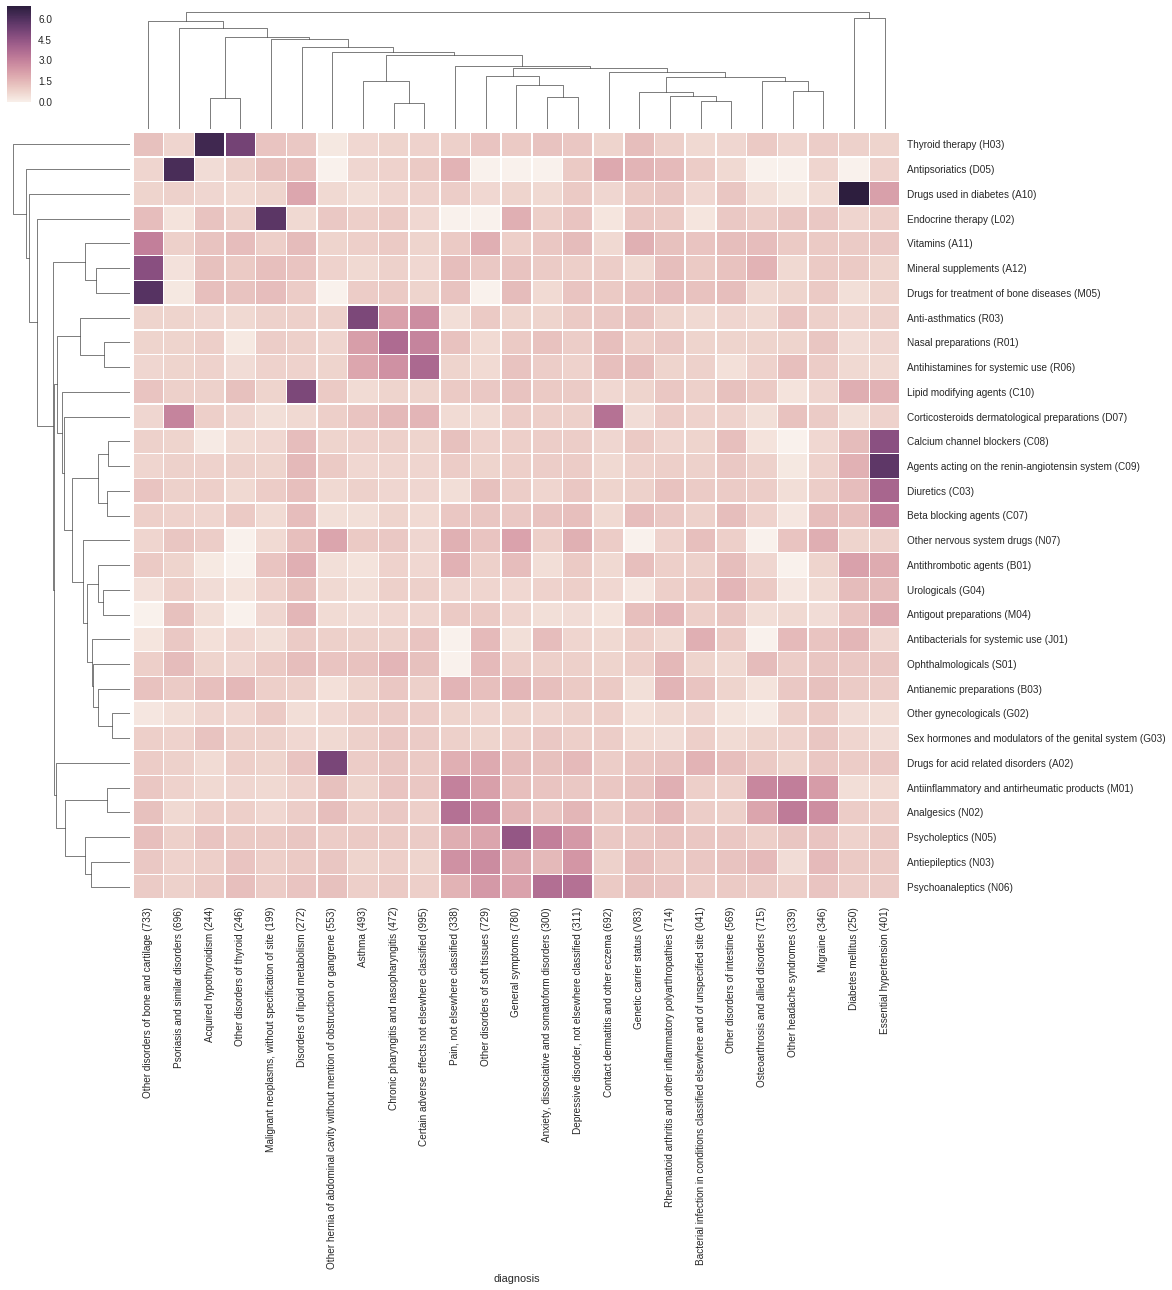

In [108]:
cg = sns.clustermap(log1p(df_filtered), linewidths=.5, figsize=(16, 16))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg

### OR table

In [113]:
df_filtered.reset_index(level=0, inplace=True)
df_filtered = pd.melt(df_filtered, id_vars=["index"], var_name="diagnosis", value_name="or")
df_filtered.rename(columns = {('index'):('medication')}, inplace=True)
df_filtered = df_filtered.sort_values(['diagnosis', 'or'], ascending=[True, False])[['diagnosis', 'medication', 'or']]
df_filtered['diagnosis_code'] = df_filtered['diagnosis'].apply(lambda st: st[st.find("(")+1:st.find(")")])
df_filtered['medication_code'] = df_filtered['medication'].apply(lambda st: st[st.find("(")+1:st.find(")")])
df_filtered.head()

,diagnosis,medication,or,diagnosis_code,medication_code
78,Acquired hypothyroidism (244),Thyroid therapy (H03),618.555055,244,H03
67,Acquired hypothyroidism (244),Antianemic preparations (B03),2.853372,244,B03
83,Acquired hypothyroidism (244),Drugs for treatment of bone diseases (M05),2.835380,244,M05
65,Acquired hypothyroidism (244),Mineral supplements (A12),2.653588,244,A12
80,Acquired hypothyroidism (244),Endocrine therapy (L02),2.506420,244,L02


In [118]:
def get_interaction_count(row, m):
    return m[row['medication_code']][row['diagnosis_code']]

def get_diagnosis_count(row, m):
    return m[row['diagnosis_code']][row['diagnosis_code']]

In [120]:
df_filtered_count = df_filtered.copy()
coocurrences_matrix = pd.DataFrame(coocurrences_gcat, columns=phenotypes.columns, index=phenotypes.columns)
coocurrences_matrix_heritability = pd.DataFrame(coocurrences_heritability, columns=phenotypes.columns, index=phenotypes.columns)

df_filtered_count['interaction_count'] = df_filtered_count.apply(get_interaction_count, axis=1, m=coocurrences_matrix)
df_filtered_count['diagnosis_count'] = df_filtered_count.apply(get_diagnosis_count, axis=1, m=coocurrences_matrix)
df_filtered_count['interaction_count_heritability'] = df_filtered_count.apply(get_interaction_count, axis=1, m=coocurrences_matrix_heritability)
df_filtered_count['diagnosis_count_heritability'] = df_filtered_count.apply(get_diagnosis_count, axis=1, m=coocurrences_matrix_heritability)
df_filtered_count

,diagnosis,medication,or,diagnosis_code,medication_code,interaction_count,diagnosis_count,interaction_count_heritability,diagnosis_count_heritability
78,Acquired hypothyroidism (244),Thyroid therapy (H03),618.555055,244,H03,404,436,103,110
67,Acquired hypothyroidism (244),Antianemic preparations (B03),2.853372,244,B03,11,436,2,110
83,Acquired hypothyroidism (244),Drugs for treatment of bone diseases (M05),2.835380,244,M05,6,436,1,110
65,Acquired hypothyroidism (244),Mineral supplements (A12),2.653588,244,A12,14,436,2,110
80,Acquired hypothyroidism (244),Endocrine therapy (L02),2.506420,244,L02,3,436,1,110
76,Acquired hypothyroidism (244),Sex hormones and modulators of the genital sys...,2.503006,244,G03,112,436,23,110
64,Acquired hypothyroidism (244),Vitamins (A11),2.482085,244,A11,10,436,2,110
86,Acquired hypothyroidism (244),Psycholeptics (N05),2.293212,244,N05,42,436,10,110
87,Acquired hypothyroidism (244),Psychoanaleptics (N06),2.000096,244,N06,53,436,18,110
88,Acquired hypothyroidism (244),Other nervous system drugs (N07),1.667189,244,N07,2,436,1,110


In [121]:
df_filtered_count = df_filtered_count[df_filtered_count['or'] > ODDS_RATIO_THRESHOLD]
df_filtered_count = df_filtered_count[
    ['diagnosis',
     'medication',
     'or',
     'diagnosis_count',
     'interaction_count',
     'diagnosis_count_heritability',
     'interaction_count_heritability'
    ]
]

In [122]:
df_filtered_count.to_csv('../output/odds-ratio/or.csv', index = False)